# Advanced Python for Data Science
### DS-GA 1019

### Homework Assignment 04
### Due date: 03/01/2023, 4:00PM
### Student's Name: Giulio Duregon
### Student's e-mail: gjd9961@nyu.edu

# Problem 1 (100 points)

The task is to optimize your solutions by using "line_profiler". 

Your submission "spring2023_sol04_yourid.ipynb" will contain:
- the first part is your original solution (a solution that you originally wrote); 
- the second part is your final, optimized solution after using line_profiler; 
- both of which will include the line_profiler results, and your detailed comments.


The problem is to simulate a random motion of $n$ objects over a discrete time. 

Concretely, there is:
- a unit square $[0,1]^2$, 
- $n$ points within the unit square, 
- and the time is discrete $t=0, 1, 2, \dots$. 

At time $t=0$, the positions of $n$ points are randomly and uniformly distributed within the unit square; call these positions $\{p_0, p_1, p_2,\dots, p_{n-1}\}$. 

At every time step $t \geq 0$, every point $i$, chooses to randomly move in one of four directions: left, right, up, down. The distance is also random uniform number on $[0, \delta]$, where $\delta$ is given. 

That is, at every time step $t$ and for every $i$ we generate a random move as: 
$$ p_i := p_i + r_i \cdot u_i$$
where 
$$ r_i \sim uniform[0, \delta],$$ 
and 
$u_i$ represents a random direction, i.e. a randomly chosen vector among $(-1, 0), (1, 0), (0, -1), (0, 1)$.

**Dynamics**

Now, one would like to examine and plot the diagram of the minimum distance $d_{\min}$ among these $n$ points over $T$ iterations.

The task is to complete the rest of this notebook, where definitions of the functions main_orignal and main_optimized are given below. 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(100)

In [2]:
%load_ext line_profiler

---

### The original code description: 

For my first attempt, I utilize several helper functions to accomplish the goal of our simulation:

- `gen_directions(n,delta)`- *Generates n vectors UP $(0,1)$ DOWN $(0,-1)$ LEFT $(-1,0)$ RIGHT $(1,0)$ scaled by a magnitude sampled from a uniform distribution $[0,delta)$*

- `gen_points(n)` - *Generates n 2-dimensional uniformally sampled points from $[0,1]$*
- `get_distance(n)`: *Helper function to calculate the Euclidean distance of a pair ($x1,x2 \in \mathbb{R}^2$) of 2-d coordinates*
- `enforce_boundary` - *Helper function that ensures that after each iteration of the simulation, points stay bounded in the $[0,1]$ unit sphere*
- `get_min_distance_val(points)` - *Function that iteratively compares combinations of 2 points
    and evaluates their distances*
 
Further, there is one Global Variable that is reference in `gen_directions`, a dictionary mapping integer values to 2-d coordinate directions (described by $u_i$ in the problem statement):
- `DIRECTIONS = {0: (-1,0), 1: (1,0), 2: (0,-1), 3: (0,1)}`

Where each value in `DIRECTIONS` is of type `np.array`

The main function, `main_original(n,delta,T)` is rather simple: it starts by generating a list object used to store the desired output of minimum distances, then it calls `gen_points(n)` to generate the uniformly sampled points for simulation. It iterates $T$ times, each time updating the position of each point by calling `gen_directions(n,delta)`, (then ensuring each point stays within the boundary by calling `enforce_boundary`), then feeding the shifted points to `get_min_distance_val(points)`. This is where the majority of the computation cost comes from: `get_min_distance_val` has a nested for loop, making the algorithm $\mathcal{O}(n^2)$ time complexity. Furthermore, the function needs to call `get_distance` on every pair of points it considers. I suspect that this is where the major improvements for time performance lie.

---


In [3]:
# Directions global used in gen_directions
# Defines 0: Down, (-1,0) etc..
DIRECTIONS = {0: np.array((-1,0)),
             1: np.array((1,0)),
             2: np.array((0,-1)),
             3: np.array((0,1))}

def gen_directions(n, delta):
    """
    Generates n vectors UP (0,1) DOWN (0,-1) LEFT (-1,0) RIGHT (1,0)
    scaled by a magnitude sampled from a uniform distribution [0,delta)
    """
    magnitude_arr = np.random.uniform(0,delta, size=n)
    # Generates a uniform random list of values, V, where \{0,1,2,3\} := V
    random_array = np.random.uniform(0,1,size=n) // 0.25
    
    # Map each value in V to a direction, either DOWN, UP, LEFT, or RIGHT
    return np.array([DIRECTIONS[x] * m for x, m in zip(random_array, magnitude_arr)])

def gen_points(n):
    """
    Generates n 2-dimensional uniformally sampled points from 0,1
    return type: np.array
    """
    return np.random.uniform(0.0,1.0,size=(n,2))

def get_distance(point1, point2):
    """
    Helper function to calculate the Euclidean distance of a pair of 2-d coordinates
    $$distance = \sqrt(\sum_i={1}^n (point1_i - point2_i)^2)$$
    """
    x1, y1 = point1
    x2, y2 = point2
    return ((x1-x2)**2 + (y1-y2)**2) ** (1/2)

def get_min_distance_val(points):
    """
    Function that iteratively compares combinations of 2 points
    and evaluates their distances. 
    
    ### Returns
    min_distance: float - the minimum distance for all pairs of points.
    """
    # Tuple pair book keeping
    seen_set = set()
    
    # Initializing to a high value, in this case 2,
    # as no points in the 1,0 unit square can 
    min_distance = 3
    
    # Double for loop O(n^2) time complexity
    for point1 in points:
        x1, y1 = point1 # Convenience
        for point2 in points:
            x2,y2 = point2 # Convenience
            # Don't include point1/point2 if they are the same point
            # Don't include unecessary points as Dist(a,b) = Dist(b,a)
            if  (x1!=x2 and y1!=y2) and ((x1,y1),(x2,y2)) not in seen_set:
                # Calculate Distance
                distance = get_distance(point1, point2)
                # Add to seen
                seen_set.add(((x1,y1),(x2,y2)))
                # Update min distance
                min_distance = min(min_distance, distance)
    return min_distance

def enforce_boundary(points):
    """
    Helper function to ensure that all points stay in the [0,1]
    unit square boundary after each iteration of the simulation
    """
    # Iterate over all points
    for i in range(len(points)):
        # Unpack tuple of points
        x,y = points[i]
        
        # Enforce x,y points to be in [0,1]
        x = max(0, x)
        x = min(1,x)
        y = max(0,y)
        y = min(1,y)
        
        # Overwrite values in index - inplace modification
        points[i] = (x,y)
                
                    
                

def main_original(n, delta, T): 
    """ 
    n: is the number of uniformly at random generated points in the unit square 
    delta: a maximal move of a point in one of four random directions: left, right, up, or down 
    T: number of iterations
    return: 
    lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
    it is a list of reals of length T"""

    # Initialize list to hold return values, generate points
    lst_of_min_distances = []
    points = gen_points(n)
    
    for _ in range(T):
        
        # Nudge points 
        points += gen_directions(n, delta)
        
        # Ensure that all points stay in the [0,1] unit square
        enforce_boundary(points)
        
        # Get the min distance, and append
        lst_of_min_distances.append(get_min_distance_val(points))
    
    return lst_of_min_distances


In [4]:
n = 1500
delta = 1.0 / n
T = 40

In [5]:
%lprun -f main_original lst_min_dist = main_original(n, delta, T)

len: 40


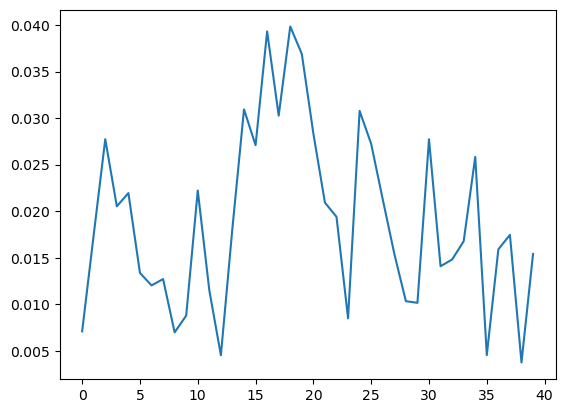

In [6]:
# plot the diagram of the minimum distances:
# where we rescale distance with by factor $\sqrt{n}$:
print("len:", len(lst_min_dist))
plt.plot(range(T), np.array(lst_min_dist) * np.sqrt(n))
plt.show()

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    79                                           def main_original(n, delta, T): 
    80                                               """ 
    81                                               n: is the number of uniformly at random generated points in the unit square 
    82                                               delta: a maximal move of a point in one of four random directions: left, right, up, or down 
    83                                               T: number of iterations
    84                                               return: 
    85                                               lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
    86                                               it is a list of reals of length T"""
    87                                           
    88                                               # Initialize list to hold return values, generate points
    89         1          7.0      7.0      0.0      lst_of_min_distances = []
    90         1        412.0    412.0      0.0      points = gen_points(n)
    91                                               
    92        41        110.0      2.7      0.0      for _ in range(T):
    93                                                   
    94                                                   # Nudge points 
    95        40      80006.0   2000.2      0.0          points += gen_directions(n, delta)
    96                                                   
    97                                                   # Ensure that all points stay in the [0,1] unit square
    98        40     112338.0   2808.4      0.0          enforce_boundary(points)
    99                                                   
   100                                                   # Get the min distance, and append
   101        40  272382011.0 6809550.3     99.9          lst_of_min_distances.append(get_min_distance_val(points))
   102                                               
   103         1          1.0      1.0      0.0      return lst_of_min_distances

---

### The optimized code description: 

My optimized solution is very similar to my first attempt, with some key differences. Firstly, I moved the `DIRECTIONS` dictionary into the `main_optimized` function, no longer having it as a global variable. This reduces some of the lookup time necessary when adjusting the position of each point in the simulation. 

The second optimization, and probably the first real impactful one, was getting rid of function calls and adding the the body of each helper function (see the unoptimized version) to the body of the `main_optimizated` function. This gets rid of some of the overhead associated with function calls, i.e. adding frames to the stack and sorting out local variables and return addresses. 

A third minor optimization, was I used `itertools.starmap` to enforce that points after adjustment still fell in the unit square boundary.

The fourth optimzation was the most impactful, rather than use an iterative approach to find combinations of points and then calculate their euclidean distance, I `np.linalg.norm` on a matrix of pairwise differences of points in the array. This function, being vectorized, ran incredibly fast, and was a much better way to perform the computation than I had tried previously.  This provided a powerful speedup as a double nested for loop was not necessary, I didn't have to implement any additional logic about pairs of points that had or haden't been seen. Lastly, I used an anonymous lambda function to calculate the euclidean distance between each pair rather than a designated first-class function that would require pushing and popping from the function call stack.

Overall, the time improvements were quite noticeble, shaving off ~270s in total. The original time was about 273s, while the optimized version ran in 2-3s.

---


In [7]:
import itertools
def main_optimized(n, delta, T): 
    """ 
    n: is the number of uniformly at random generated points in the unit square 
    delta: a maximal move of a point in one of four random directions: left, right, up, or down 
    T: number of iterations
    return: 
    lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
    it is a list of reals of length T"""
    
    # Set directions inside main function, rather than global variable
    DIRECTIONS = {0: np.array((-1,0)),
             1: np.array((1,0)),
             2: np.array((0,-1)),
             3: np.array((0,1))}
    
    # Initialize return list, generate points
    lst_of_min_distances = []
    points = np.random.uniform(0.0,1.0,size=(n,2))
    
    # Simulate for however many interations
    for _ in range(T):
        
        # Generate random array of magnitudes (r_i)
        magnitude_arr = np.random.uniform(0,delta, size=n)
        
        # Generates a uniform random list of values, u_i,\dots,u_n where \u_i \in {0,1,2,3\} := V
        random_array = np.random.randint(0,4,size=n)
        
        # Map each value in V to a direction, either DOWN, UP, LEFT, or RIGHT
        points += np.array([DIRECTIONS[x] * m for x, m in zip(random_array, magnitude_arr)])
        
        # Enforce upper bound with starmap
        points = itertools.starmap(lambda x,y: np.array((min(x,1),min(y,1))), points)
        # Enforce lower bound with starmap
        points = itertools.starmap(lambda x,y: np.array((max(x,0),max(y,0))), points)
        
        # Condense points into list
        points = np.array(list(points))
        
        # Calculate the euclidean distances
        # Little np trick here, returns a matrix of pairwise distances
        # Then use linalg.norm to calculate the euclidean distance
        unfixed_distances = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)
        
        # The diagonal will always be 0, so add 3 to have it be always greater than min norm
        distances = unfixed_distances + (3*np.eye(*unfixed_distances.shape))
        
        # Append the minimum of the distances list
        lst_of_min_distances.append(distances.min())
        
    # Return results
    return lst_of_min_distances

In [8]:
n = 1500
delta = 1.0 / n
T = 40

In [9]:
%lprun -f main_optimized lst_min_dist = main_optimized(n, delta, T)

Timer unit: 1e-06 s

Total time: 2.04241 s
File: /var/folders/rk/rwsr6gss0vz3g4fz3_kt0x0m0000gn/T/ipykernel_17855/3729200783.py
Function: main_optimized at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                           def main_optimized(n, delta, T): 
     3                                               """ 
     4                                               n: is the number of uniformly at random generated points in the unit square 
     5                                               delta: a maximal move of a point in one of four random directions: left, right, up, or down 
     6                                               T: number of iterations
     7                                               return: 
     8                                               lst_of_min_distances: of the minimum distances among all n points over times: t=0, 1, 2, \dots, T - 1,
     9                                               it is a list of reals of length T"""
    10                                               
    11                                               # Set directions inside main function, rather than global variable
    12         2         50.0     25.0      0.0      DIRECTIONS = {0: np.array((-1,0)),
    13         1          5.0      5.0      0.0               1: np.array((1,0)),
    14         1          4.0      4.0      0.0               2: np.array((0,-1)),
    15         1          4.0      4.0      0.0               3: np.array((0,1))}
    16                                               
    17                                               # Initialize return list, generate points
    18         1          3.0      3.0      0.0      lst_of_min_distances = []
    19         1        335.0    335.0      0.0      points = np.random.uniform(0.0,1.0,size=(n,2))
    20                                               
    21                                               # Simulate for however many interations
    22        41         48.0      1.2      0.0      for _ in range(T):
    23                                                   
    24                                                   # Generate random array of magnitudes (r_i)
    25        40       1280.0     32.0      0.1          magnitude_arr = np.random.uniform(0,delta, size=n)
    26                                                   
    27                                                   # Generates a uniform random list of values, u_i,\dots,u_n where \u_i \in {0,1,2,3\} := V
    28        40       1758.0     44.0      0.1          random_array = np.random.randint(0,4,size=n)
    29                                                   
    30                                                   # Map each value in V to a direction, either DOWN, UP, LEFT, or RIGHT
    31        40      71968.0   1799.2      3.5          points += np.array([DIRECTIONS[x] * m for x, m in zip(random_array, magnitude_arr)])
    32                                                   
    33                                                   # Enforce upper bound with starmap
    34        40         76.0      1.9      0.0          points = itertools.starmap(lambda x,y: np.array((min(x,1),min(y,1))), points)
    35                                                   # Enforce lower bound with starmap
    36        40         37.0      0.9      0.0          points = itertools.starmap(lambda x,y: np.array((max(x,0),max(y,0))), points)
    37                                                   
    38                                                   # Condense points into list
    39        40     144516.0   3612.9      7.1          points = np.array(list(points))
    40                                                   
    41                                                   # Calculate the euclidean distances
    42                                                   # Little np trick here, returns a matrix of pairwise distances
    43        40    1564262.0  39106.6     76.6          unfixed_distances = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)
    44                                                   
    45                                                   # The diagonal will always be 0, so add 3 to have it be always greater than min norm
    46        40      87725.0   2193.1      4.3          distances = unfixed_distances + (3*np.eye(*unfixed_distances.shape))
    47                                                   
    48                                                   # Append the minimum of the distances list
    49        40     170340.0   4258.5      8.3          lst_of_min_distances.append(distances.min())
    50                                                   
    51                                               # Return results
    52         1          1.0      1.0      0.0      return lst_of_min_distances

len: 40


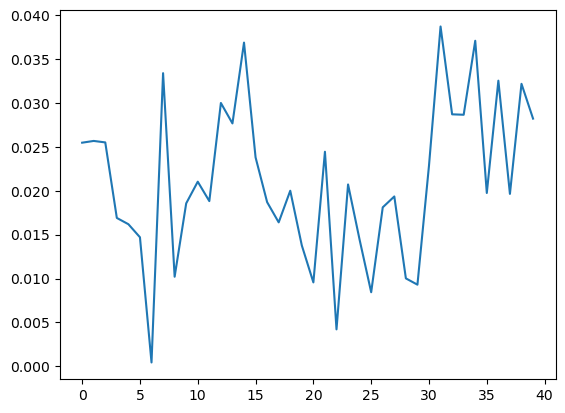

In [10]:
# plot the diagram of the minimum distances:
# where we rescale distance by a factor $\sqrt{n}$:
print("len:", len(lst_min_dist))
plt.plot(range(T), np.array(lst_min_dist) * np.sqrt(n))
plt.show()